In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek\


from itertools import combinations

In [4]:
# set 
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .config("spark.driver.memory", "32g")\
        .master("local[*]").getOrCreate()

spark_session = create_new_spark_context("FrequentItemSet")
sc = spark_session.sparkContext

In [5]:
schema = StructType([
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True),
        StructField("ORIGINE_CAR_KEY",StringType(),True),
        StructField("FINAL_CAR_KEY",StringType(),True),
        StructField("CHECK_STATUS_KEY", IntegerType(), True),
        StructField("COMPANY_ID", StringType(), True),
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

In [ ]:
df = spark_session.read.csv('/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



# Mining Frequent Paths

In this Section we are going to find the path with the most number of passes. To do this, we use the *Apriori* algorithm. The details of how this algorithm works is explained in the report document.

In [ ]:
rdd = df.rdd.map(lambda x: ((x["FINAL_CAR_KEY"], x["PASS_DAY_TIME"].day), x["DEVICE_CODE"]))

In [ ]:
traffic_rdd = rdd.groupByKey()\
                    .map(lambda x: (x[0], sorted(list(set(x[1])))))\
                    .filter(lambda x: len(x[1]) < 20)\
                    .map(lambda x: x[1])


In [ ]:
traffic_rdd.take(1)

[[22010047]]

In [11]:
def prune_candidates(x, Ck, n):
    combs = list(combinations(x, n))
    return all(i in Ck for i in combs)


def apriori(traffic_rdd, support_threshold, n):  
    if n == 1:
        f_1 = traffic_rdd.flatMap(lambda x: x)\
                .map(lambda x: (x, 1))\
                .reduceByKey(lambda x, y: x + y)\
                .filter(lambda x: x[1] >= support_threshold)\
                .map(lambda x : ([x[0]], x[1]))\
                .collect()
        f_1 = {tuple(x[0]): x[1] for x in f_1}
        return f_1
    
    Cn_1 = apriori(traffic_rdd, support_threshold, n - 1)
    f_n = traffic_rdd.flatMap(lambda x: combinations(x, n))\
                .filter(lambda x: prune_candidates(x, Cn_1, n - 1))\
                .map(lambda x: (x, 1))\
                .reduceByKey(lambda x, y: x + y)\
                .filter(lambda x: x[1] >= support_threshold)\
                .collect()
    f_n = {tuple(x[0]): x[1] for x in f_n}
    return f_n

In [ ]:
FI2 = apriori(traffic_rdd, 1000, 2)

In [ ]:
FI3 = apriori(traffic_rdd, 1000, 3)

In [ ]:
FI4 = apriori(traffic_rdd, 1000, 4)

In [ ]:
FI5 = apriori(traffic_rdd, 1000, 5)

In [ ]:
FI6 = apriori(traffic_rdd, 1000, 6)

In [20]:
# print number of frequent paths
print(f'Number of frequent paths of length 2: {len(FI2)}')
print(f'Number of frequent paths of length 3: {len(FI3)}')
print(f'Number of frequent paths of length 4: {len(FI4)}')
print(f'Number of frequent paths of length 5: {len(FI5)}')
print(f'Number of frequent paths of length 6: {len(FI6)}')

Number of frequent paths of length 2: 8786
Number of frequent paths of length 3: 9566
Number of frequent paths of length 4: 2802
Number of frequent paths of length 5: 451
Number of frequent paths of length 6: 38


In [30]:
# print the frequent paths
print("Frequent paths of length 2: ", [x for x in list(FI2)[:10]])
print("Frequent paths of length 3: ", [x for x in list(FI3)[:10]])
print("Frequent paths of length 4: ", [x for x in list(FI4)[:10]])
print("Frequent paths of length 5: ", [x for x in list(FI5)[:10]])
print("Frequent paths of length 6: ", [x for x in list(FI6)[:10]])

Frequent paths of length 2:  [(203902, 900246), (631357, 631765), (631368, 900164), (900214, 900228), (900222, 900228), (631633, 900225), (900102, 900208), (900102, 900244), (900223, 900273), (900225, 900273)]
Frequent paths of length 3:  [(631763, 900228, 900246), (631765, 900222, 900228), (631633, 900225, 900273), (205802, 900233, 900234), (631363, 900226, 900246), (631361, 900226, 900244), (900113, 900212, 900244), (900226, 900244, 900259), (205201, 900191, 22009971), (175, 900101, 900191)]
Frequent paths of length 4:  [(175, 205802, 900191, 900234), (631633, 631634, 900141, 900244), (631633, 631634, 900212, 100700841), (631633, 900212, 900222, 100700841), (631633, 900212, 900244, 22010039), (631633, 900222, 900244, 100700841), (631634, 900142, 900222, 900244), (900142, 900212, 900244, 900246), (631363, 900225, 900259, 900269), (123, 209103, 900266, 100700804)]
Frequent paths of length 5:  [(631633, 900142, 900212, 900222, 900244), (631633, 631634, 900142, 900152, 900244), (631633, 

In [31]:
FI2 = list(FI2.items())
FI3 = list(FI3.items())
FI4 = list(FI4.items())
FI5 = list(FI5.items())
FI6 = list(FI6.items())

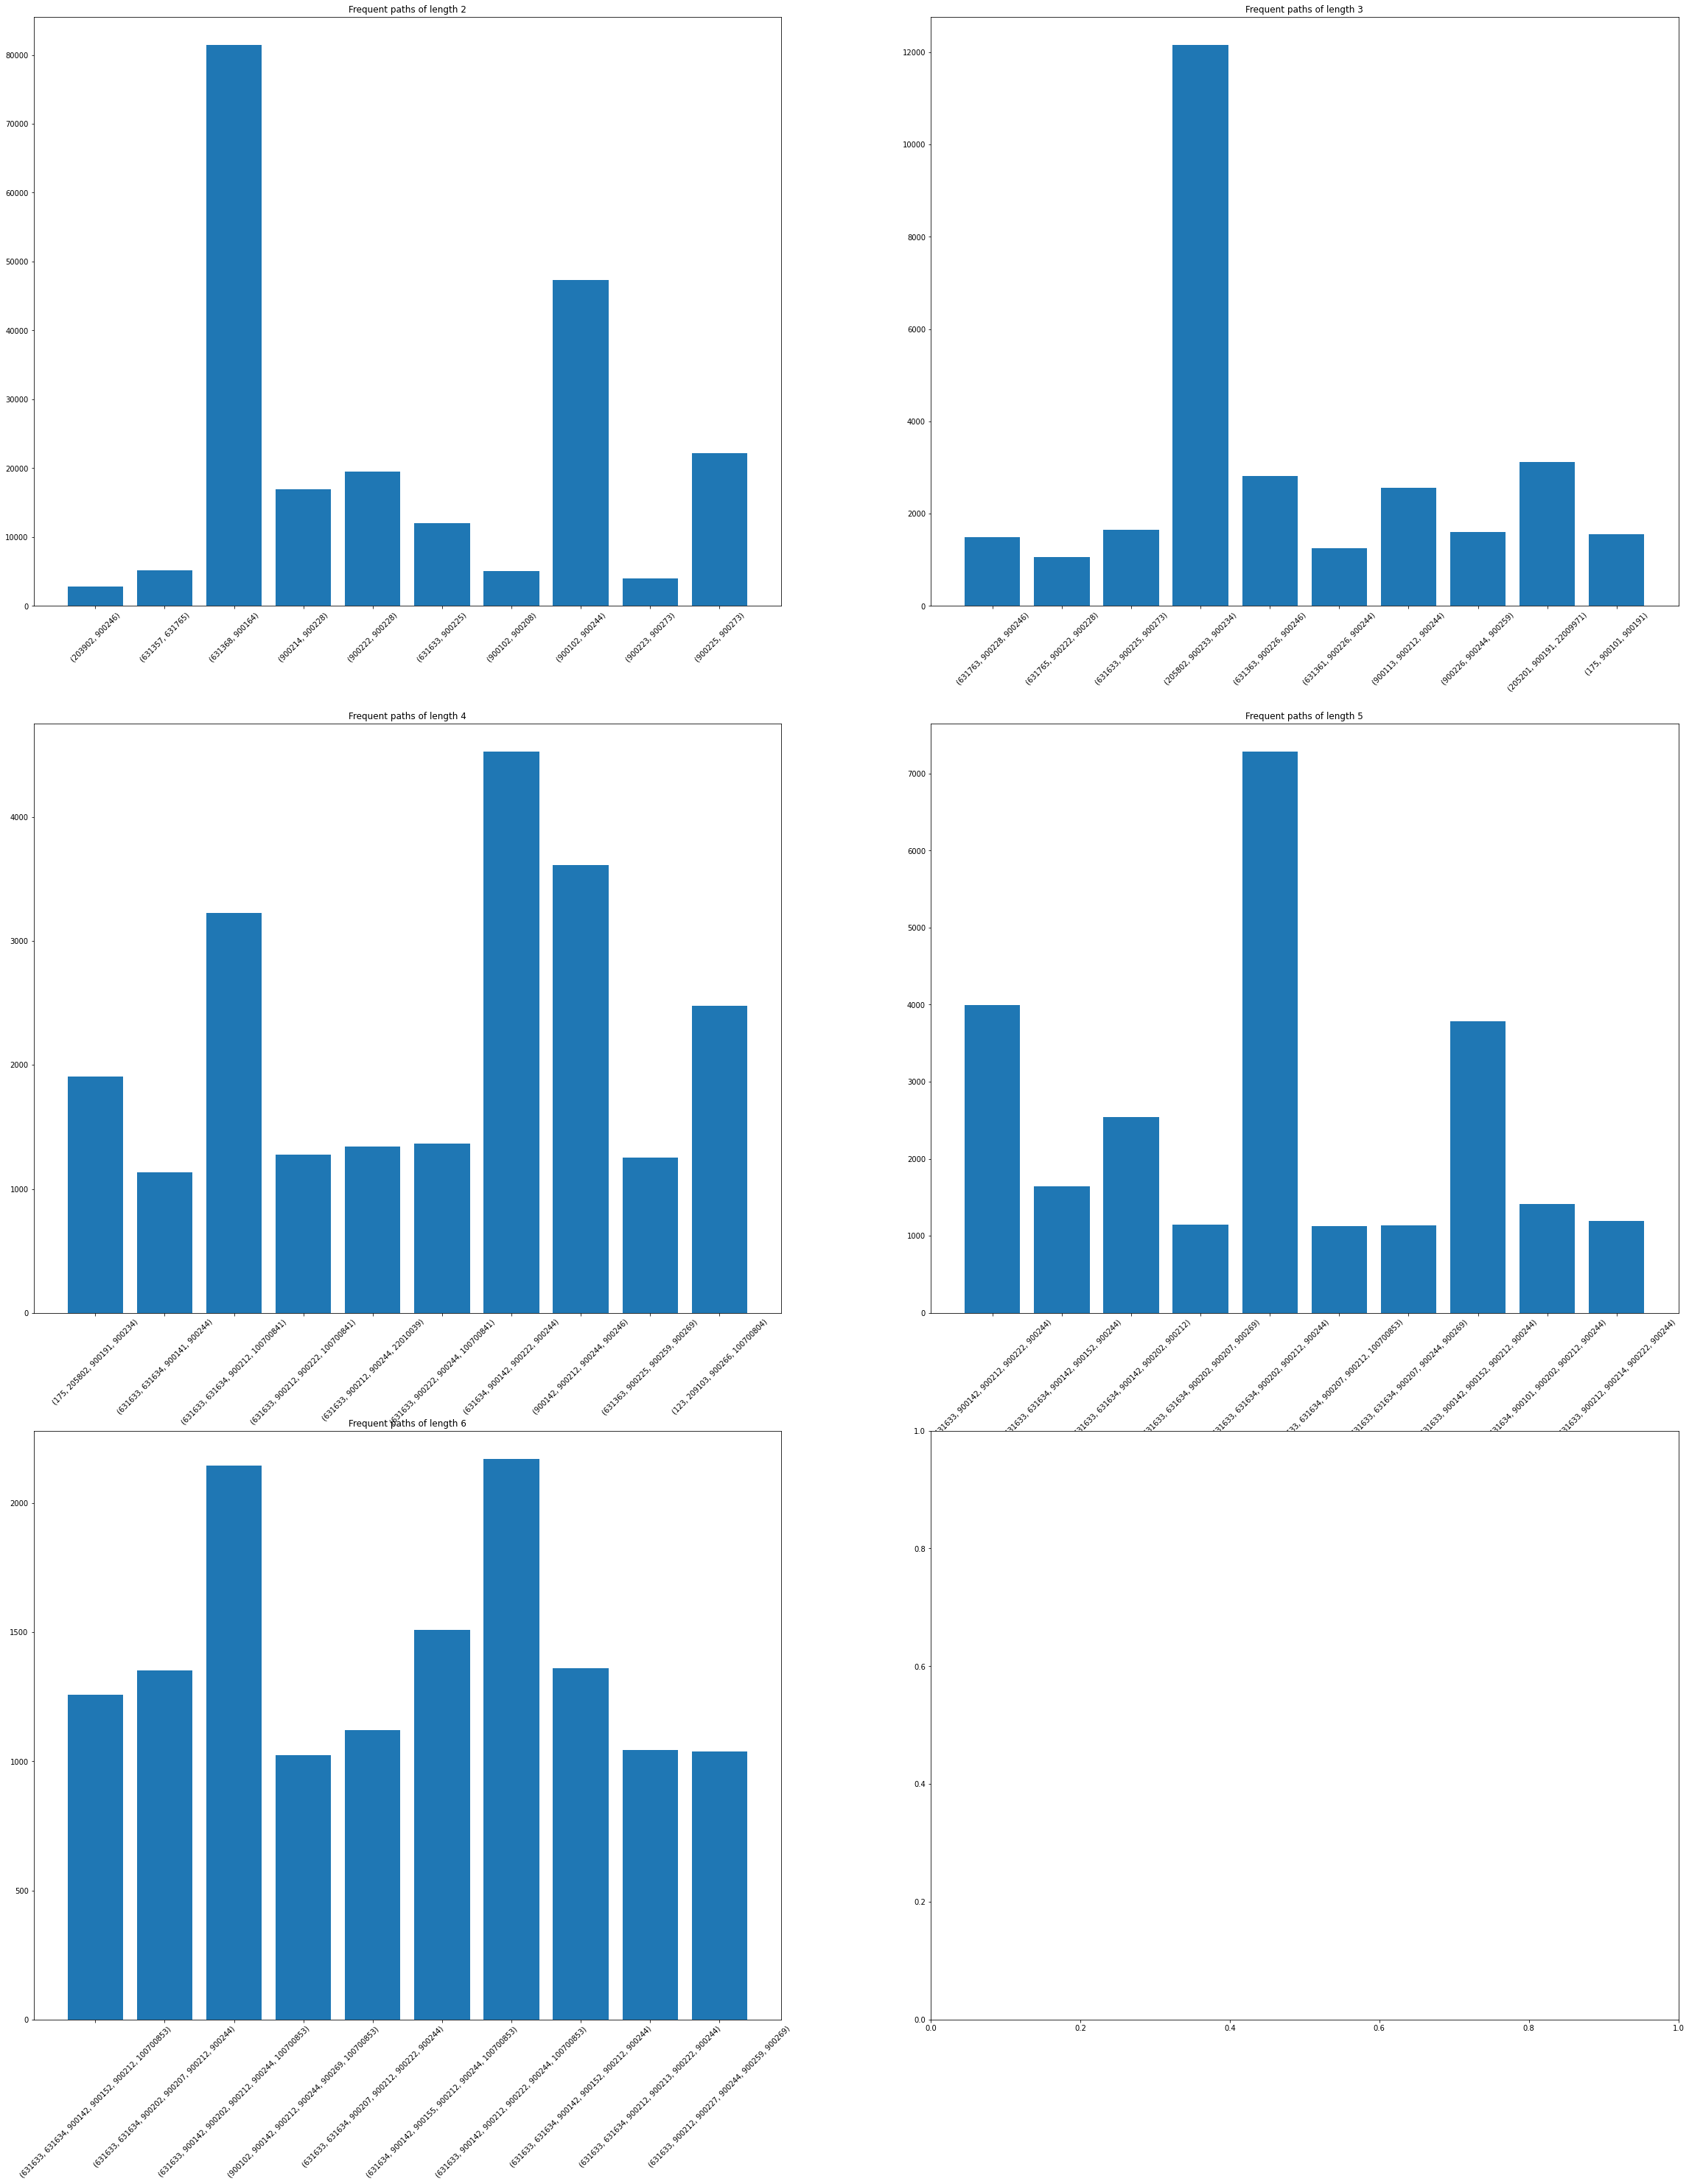

In [41]:
# on a grid of 3 x 2 subplots, plot the top 10 frequent paths of length 2, 3, 4, 5, 6
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(40, 50))
axs[0, 0].bar(range(10), [FI2[i][1] for i in range(10)])
axs[0, 0].set_title('Frequent paths of length 2')
axs[0, 0].set_xticks(range(10))
axs[0, 0].set_xticklabels([FI2[i][0] for i in range(10)], rotation=45)
axs[0, 1].bar(range(10), [FI3[i][1] for i in range(10)])
axs[0, 1].set_title('Frequent paths of length 3')
axs[0, 1].set_xticks(range(10))
axs[0, 1].set_xticklabels([FI3[i][0] for i in range(10)], rotation=45)
axs[1, 0].bar(range(10), [FI4[i][1] for i in range(10)])
axs[1, 0].set_title('Frequent paths of length 4')
axs[1, 0].set_xticks(range(10))
axs[1, 0].set_xticklabels([FI4[i][0] for i in range(10)], rotation=45)
axs[1, 1].bar(range(10), [FI5[i][1] for i in range(10)])
axs[1, 1].set_title('Frequent paths of length 5')
axs[1, 1].set_xticks(range(10))
axs[1, 1].set_xticklabels([FI5[i][0] for i in range(10)], rotation=45)
axs[2, 0].bar(range(10), [FI6[i][1] for i in range(10)])
axs[2, 0].set_title('Frequent paths of length 6')
axs[2, 0].set_xticks(range(10))
axs[2, 0].set_xticklabels([FI6[i][0] for i in range(10)], rotation=45)
plt.show()

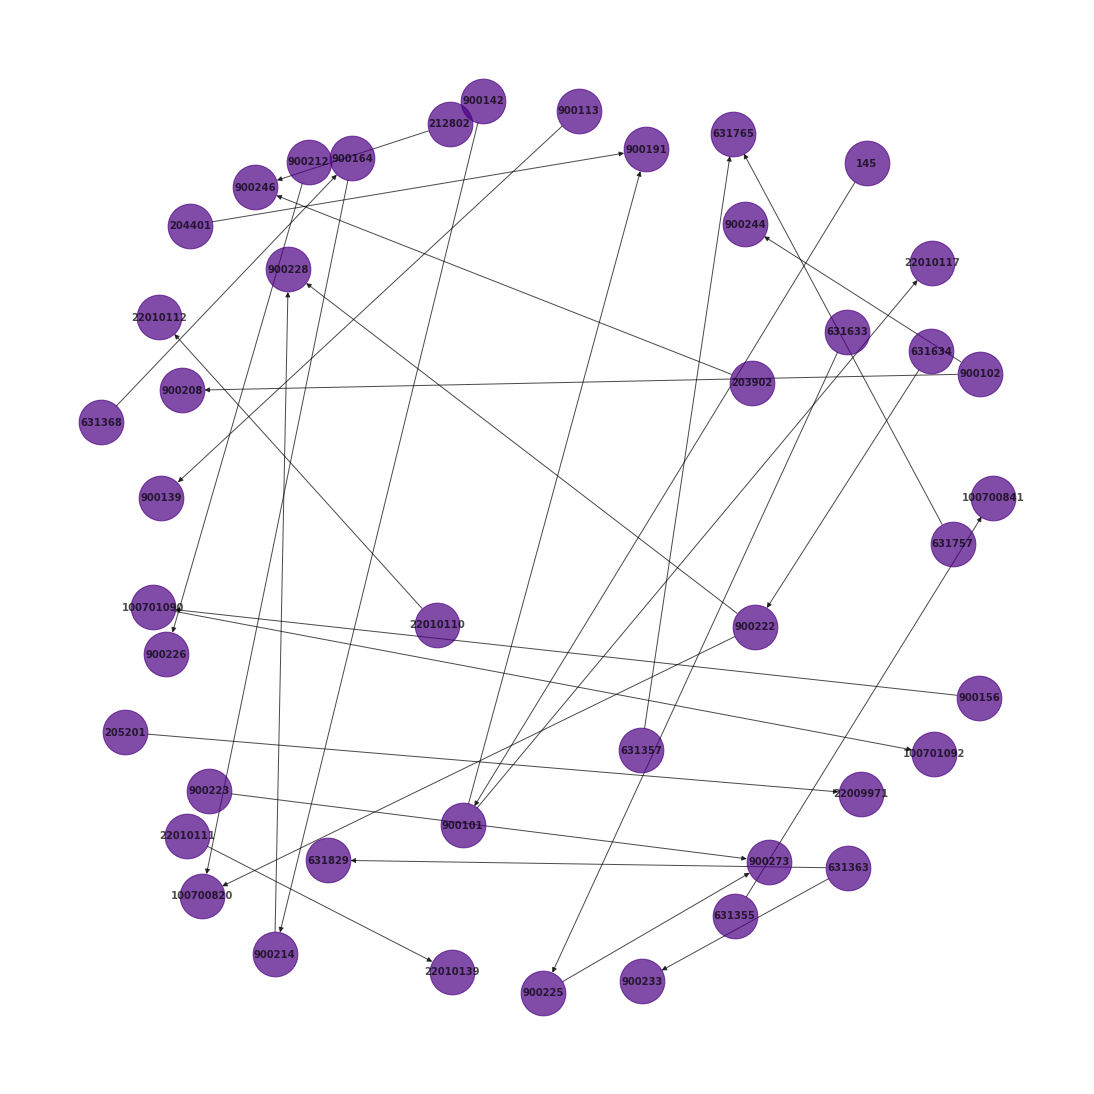

In [88]:
# visualize the frequent paths

import networkx as nx
import matplotlib.pyplot as plt


def visualize_frequent_paths(FI, n):
    G = nx.DiGraph()
    for k, v in FI[:30]:
        # if len(k) == n:
        G.add_edge(k[0], k[1])
    # add some beauty to the graph
    plt.figure(figsize=(15, 15))
    nx.draw(G, with_labels=True, node_size=2000, node_color='indigo',
            font_size=10, font_color='black', font_weight='bold',
            pos=nx.spring_layout(G, k=1, iterations=30),
            edge_color='black', width=1, alpha=0.7, arrows=True)
    plt.show()


visualize_frequent_paths(FI2, 2)


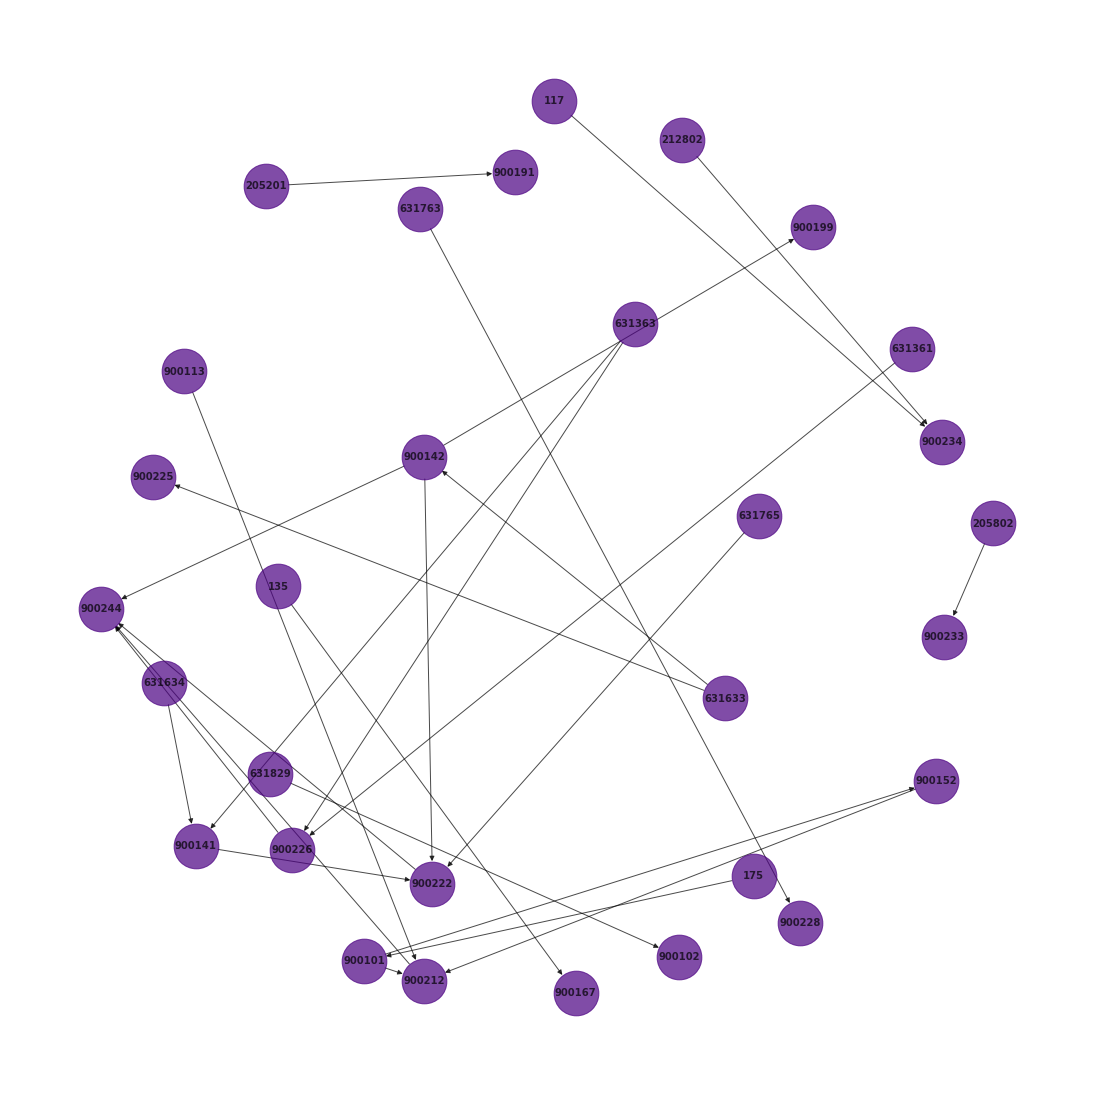

In [89]:
visualize_frequent_paths(FI3, 3)

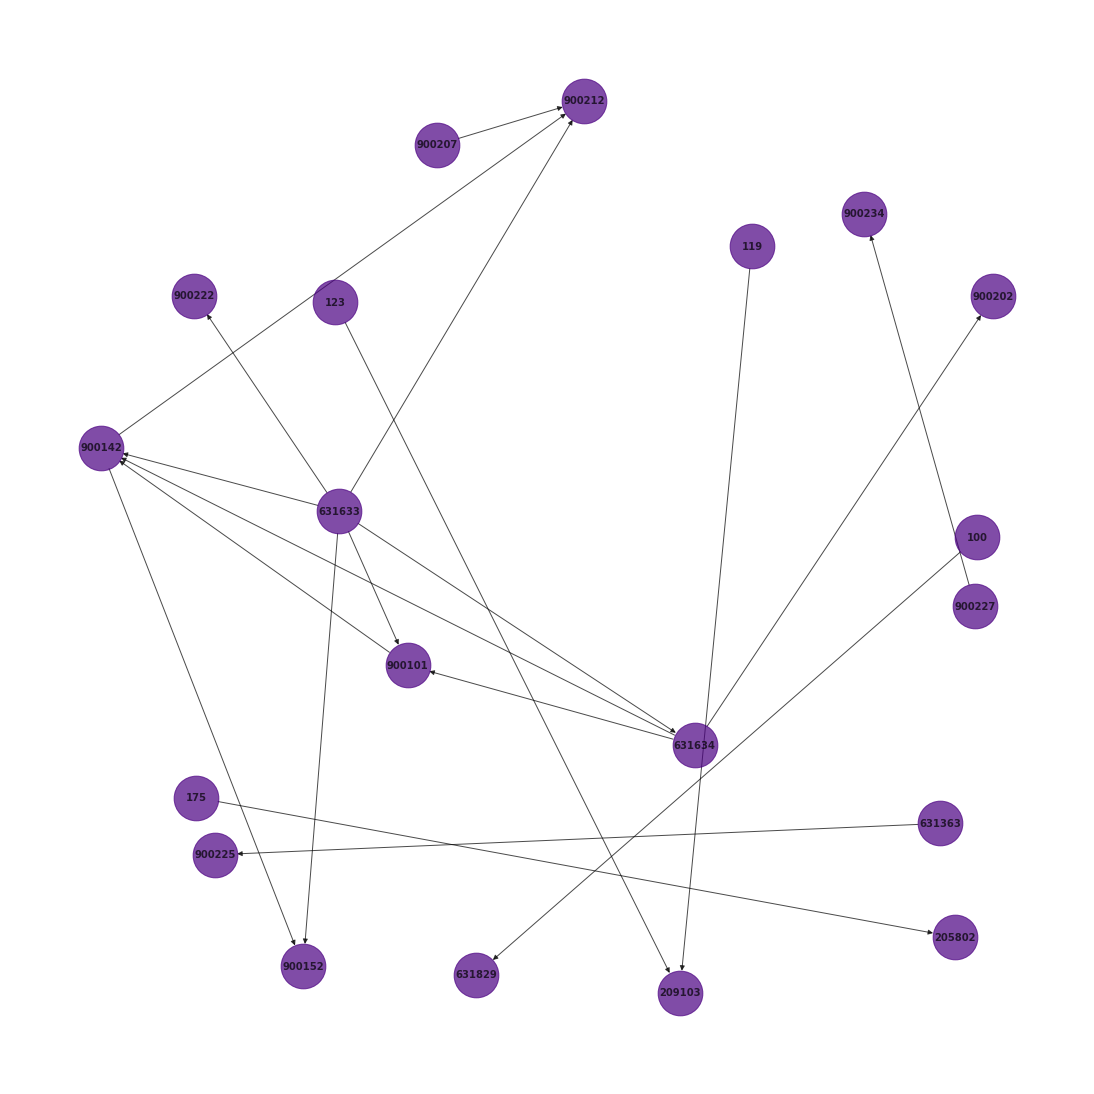

In [90]:
visualize_frequent_paths(FI4, 4)

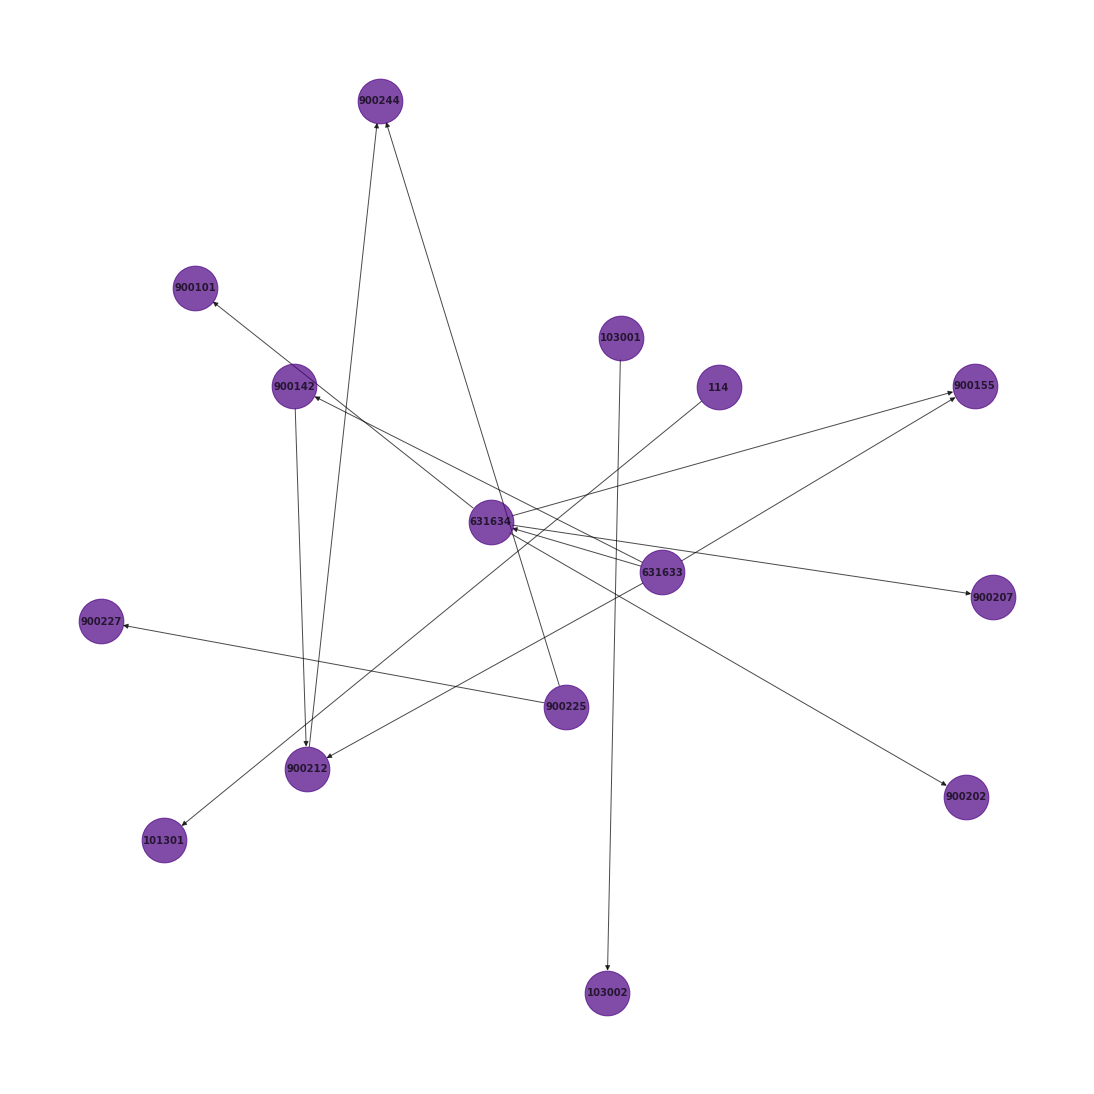

In [91]:
visualize_frequent_paths(FI5, 5)

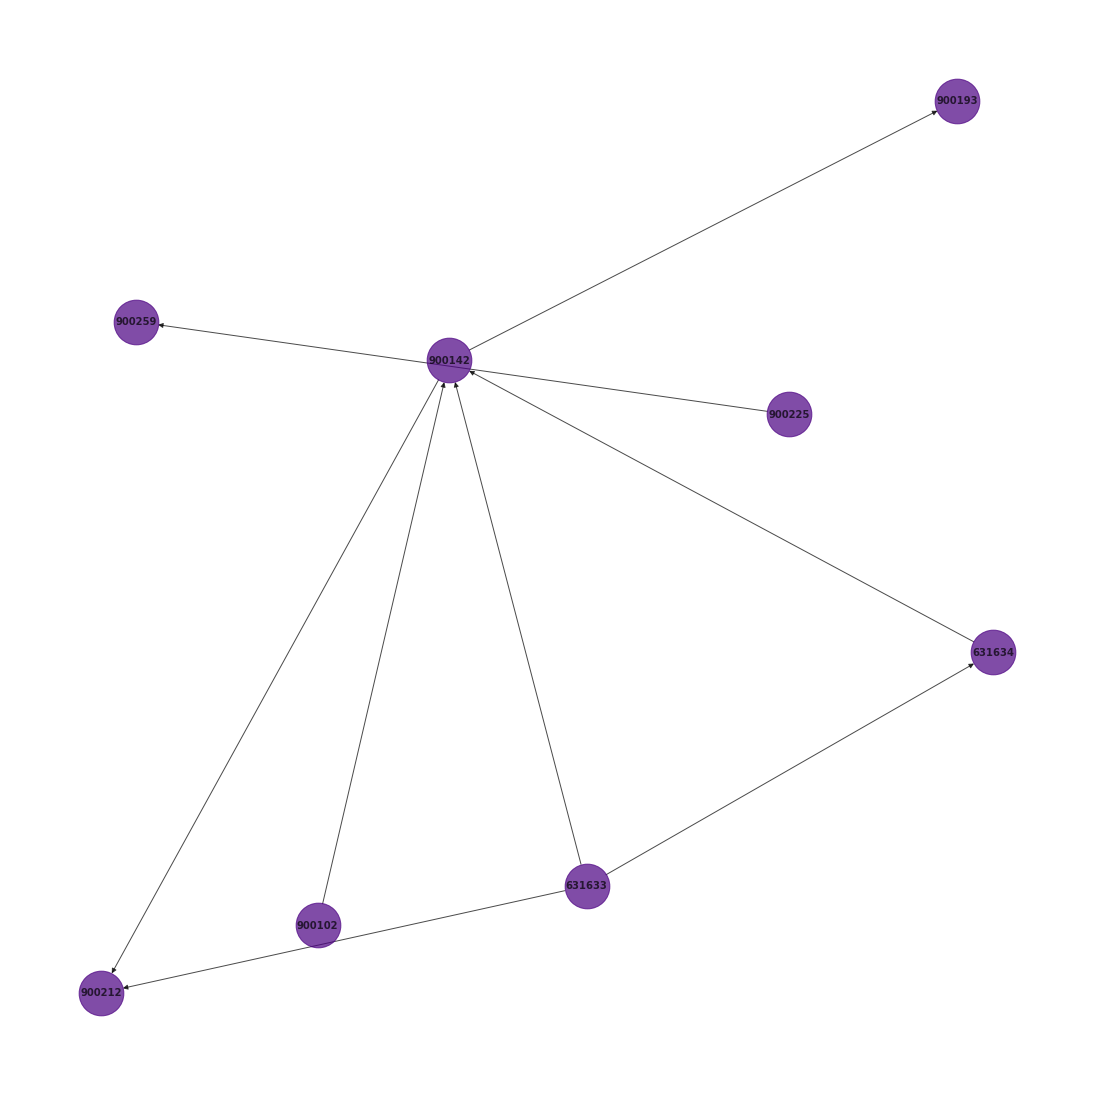

In [92]:
visualize_frequent_paths(FI6, 6)

So far we have found the association rules for a record dataset of one week. Now we split the main dataset into 4 parts, each for one week and repeat the process for each. Then we analys the results. 

In [6]:
# load the main data
df = spark_session.read.csv('/content/drive/MyDrive/MDA/Project/MDA2022ProjectData.csv', header=True, schema=schema)
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010047|      284|       63455590|     63455590|               6|       161|2021-12-22 00:59:30|
|   22010054|      284|       63566637|     64111706|               7|       161|2021-12-22 01:24:58|
|   22010057|      284|       63653636|     63653636|               6|       161|2021-12-22 00:46:37|
|   22010039|      284|       63562975|     64111706|               7|       161|2021-12-22 00:27:32|
|   22010053|      284|       63634047|     64111706|               7|       161|2021-12-22 01:29:24|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [7]:
# first get week of each date using spark functions
from pyspark.sql.functions import weekofyear

df = df.withColumn("week", weekofyear(df["PASS_DAY_TIME"].cast("date")))

In [8]:
rdd = df.rdd.map(lambda x: (
    x["FINAL_CAR_KEY"], x["DEVICE_CODE"], x["PASS_DAY_TIME"], x["week"]))
rdd.take(1)

[('63455590', 22010047, datetime.datetime(2021, 12, 22, 0, 59, 30), 51)]

In [9]:
rdd1 = rdd.filter(lambda x: x[3] == 51).map(lambda x: ((x[0], x[2].day), x[1]))
rdd2 = rdd.filter(lambda x: x[3] == 52).map(lambda x: ((x[0], x[2].day), x[1]))
rdd3 = rdd.filter(lambda x: x[3] == 1).map(lambda x: ((x[0], x[2].day), x[1]))
rdd4 = rdd.filter(lambda x: x[3] == 2).map(lambda x: ((x[0], x[2].day), x[1]))

In [ ]:
rdd1.take(5)

[(('63455590', 22), 22010047),
 (('64111706', 22), 22010054),
 (('63653636', 22), 22010057),
 (('64111706', 22), 22010039),
 (('64111706', 22), 22010053)]

In [ ]:
traffic_rdd1 = rdd1.groupByKey()\
                    .map(lambda x: (x[0], sorted(list(set(x[1])))))\
                    .filter(lambda x: len(x[1]) < 20)\
                    .map(lambda x: x[1])

In [ ]:
traffic_rdd1.take(1)

[[22010039]]

In [ ]:
frequent_paths_week1 = []
for i in range(2, 6 + 1):
    frequent_paths_week1.append(apriori(traffic_rdd1, 1000, i))
    print(f"found frequent paths of length {i}.")

found frequent paths of length 2.
found frequent paths of length 3.
found frequent paths of length 4.
found frequent paths of length 5.


In [ ]:
traffic_rdd2 = rdd2.groupByKey()\
                    .map(lambda x: (x[0], sorted(list(set(x[1])))))\
                    .filter(lambda x: len(x[1]) < 20)\
                    .map(lambda x: x[1])

In [ ]:
traffic_rdd2.take(1)

[[121, 900228, 900233, 900248, 900266, 900272]]

In [ ]:
frequent_paths_week2 = []
for i in range(2, 6 + 1):
    frequent_paths_week2.append(apriori(traffic_rdd2, 1000, i))
    print(f"found frequent paths of length {i}.")

found frequent paths of length 2.
found frequent paths of length 3.
found frequent paths of length 4.
found frequent paths of length 5.
found frequent paths of length 6.


In [ ]:
traffic_rdd3 = rdd3.groupByKey()\
                    .map(lambda x: (x[0], sorted(list(set(x[1])))))\
                    .filter(lambda x: len(x[1]) < 20)\
                    .map(lambda x: x[1])

In [ ]:
traffic_rdd3.take(1)

[[635695]]

In [ ]:
frequent_paths_week3 = []
for i in range(2, 6 + 1):
    frequent_paths_week3.append(apriori(traffic_rdd3, 1000, i))
    print(f"found frequent paths of length {i}.")

found frequent paths of length 2.
found frequent paths of length 3.
found frequent paths of length 4.
found frequent paths of length 5.
found frequent paths of length 6.


In [12]:
traffic_rdd4 = rdd4.groupByKey()\
                    .map(lambda x: (x[0], sorted(list(set(x[1])))))\
                    .filter(lambda x: len(x[1]) < 20)\
                    .map(lambda x: x[1])

In [13]:
traffic_rdd4.take(1)

[[631357, 631829, 900222]]

In [14]:
frequent_paths_week4 = []
for i in range(2, 6 + 1):
    frequent_paths_week4.append(apriori(traffic_rdd4, 1000, i))
    print(f"found frequent paths of length {i}.")

found frequent paths of length 2.
found frequent paths of length 3.
found frequent paths of length 4.
found frequent paths of length 5.
found frequent paths of length 6.


In [111]:
frequent_paths_week1 = list(map(lambda x: list(x.items()), frequent_paths_week1))
frequent_paths_week2 = list(map(lambda x: list(x.items()), frequent_paths_week2))
frequent_paths_week3 = list(map(lambda x: list(x.items()), frequent_paths_week3))
frequent_paths_week4 = list(map(lambda x: list(x.items()), frequent_paths_week4))

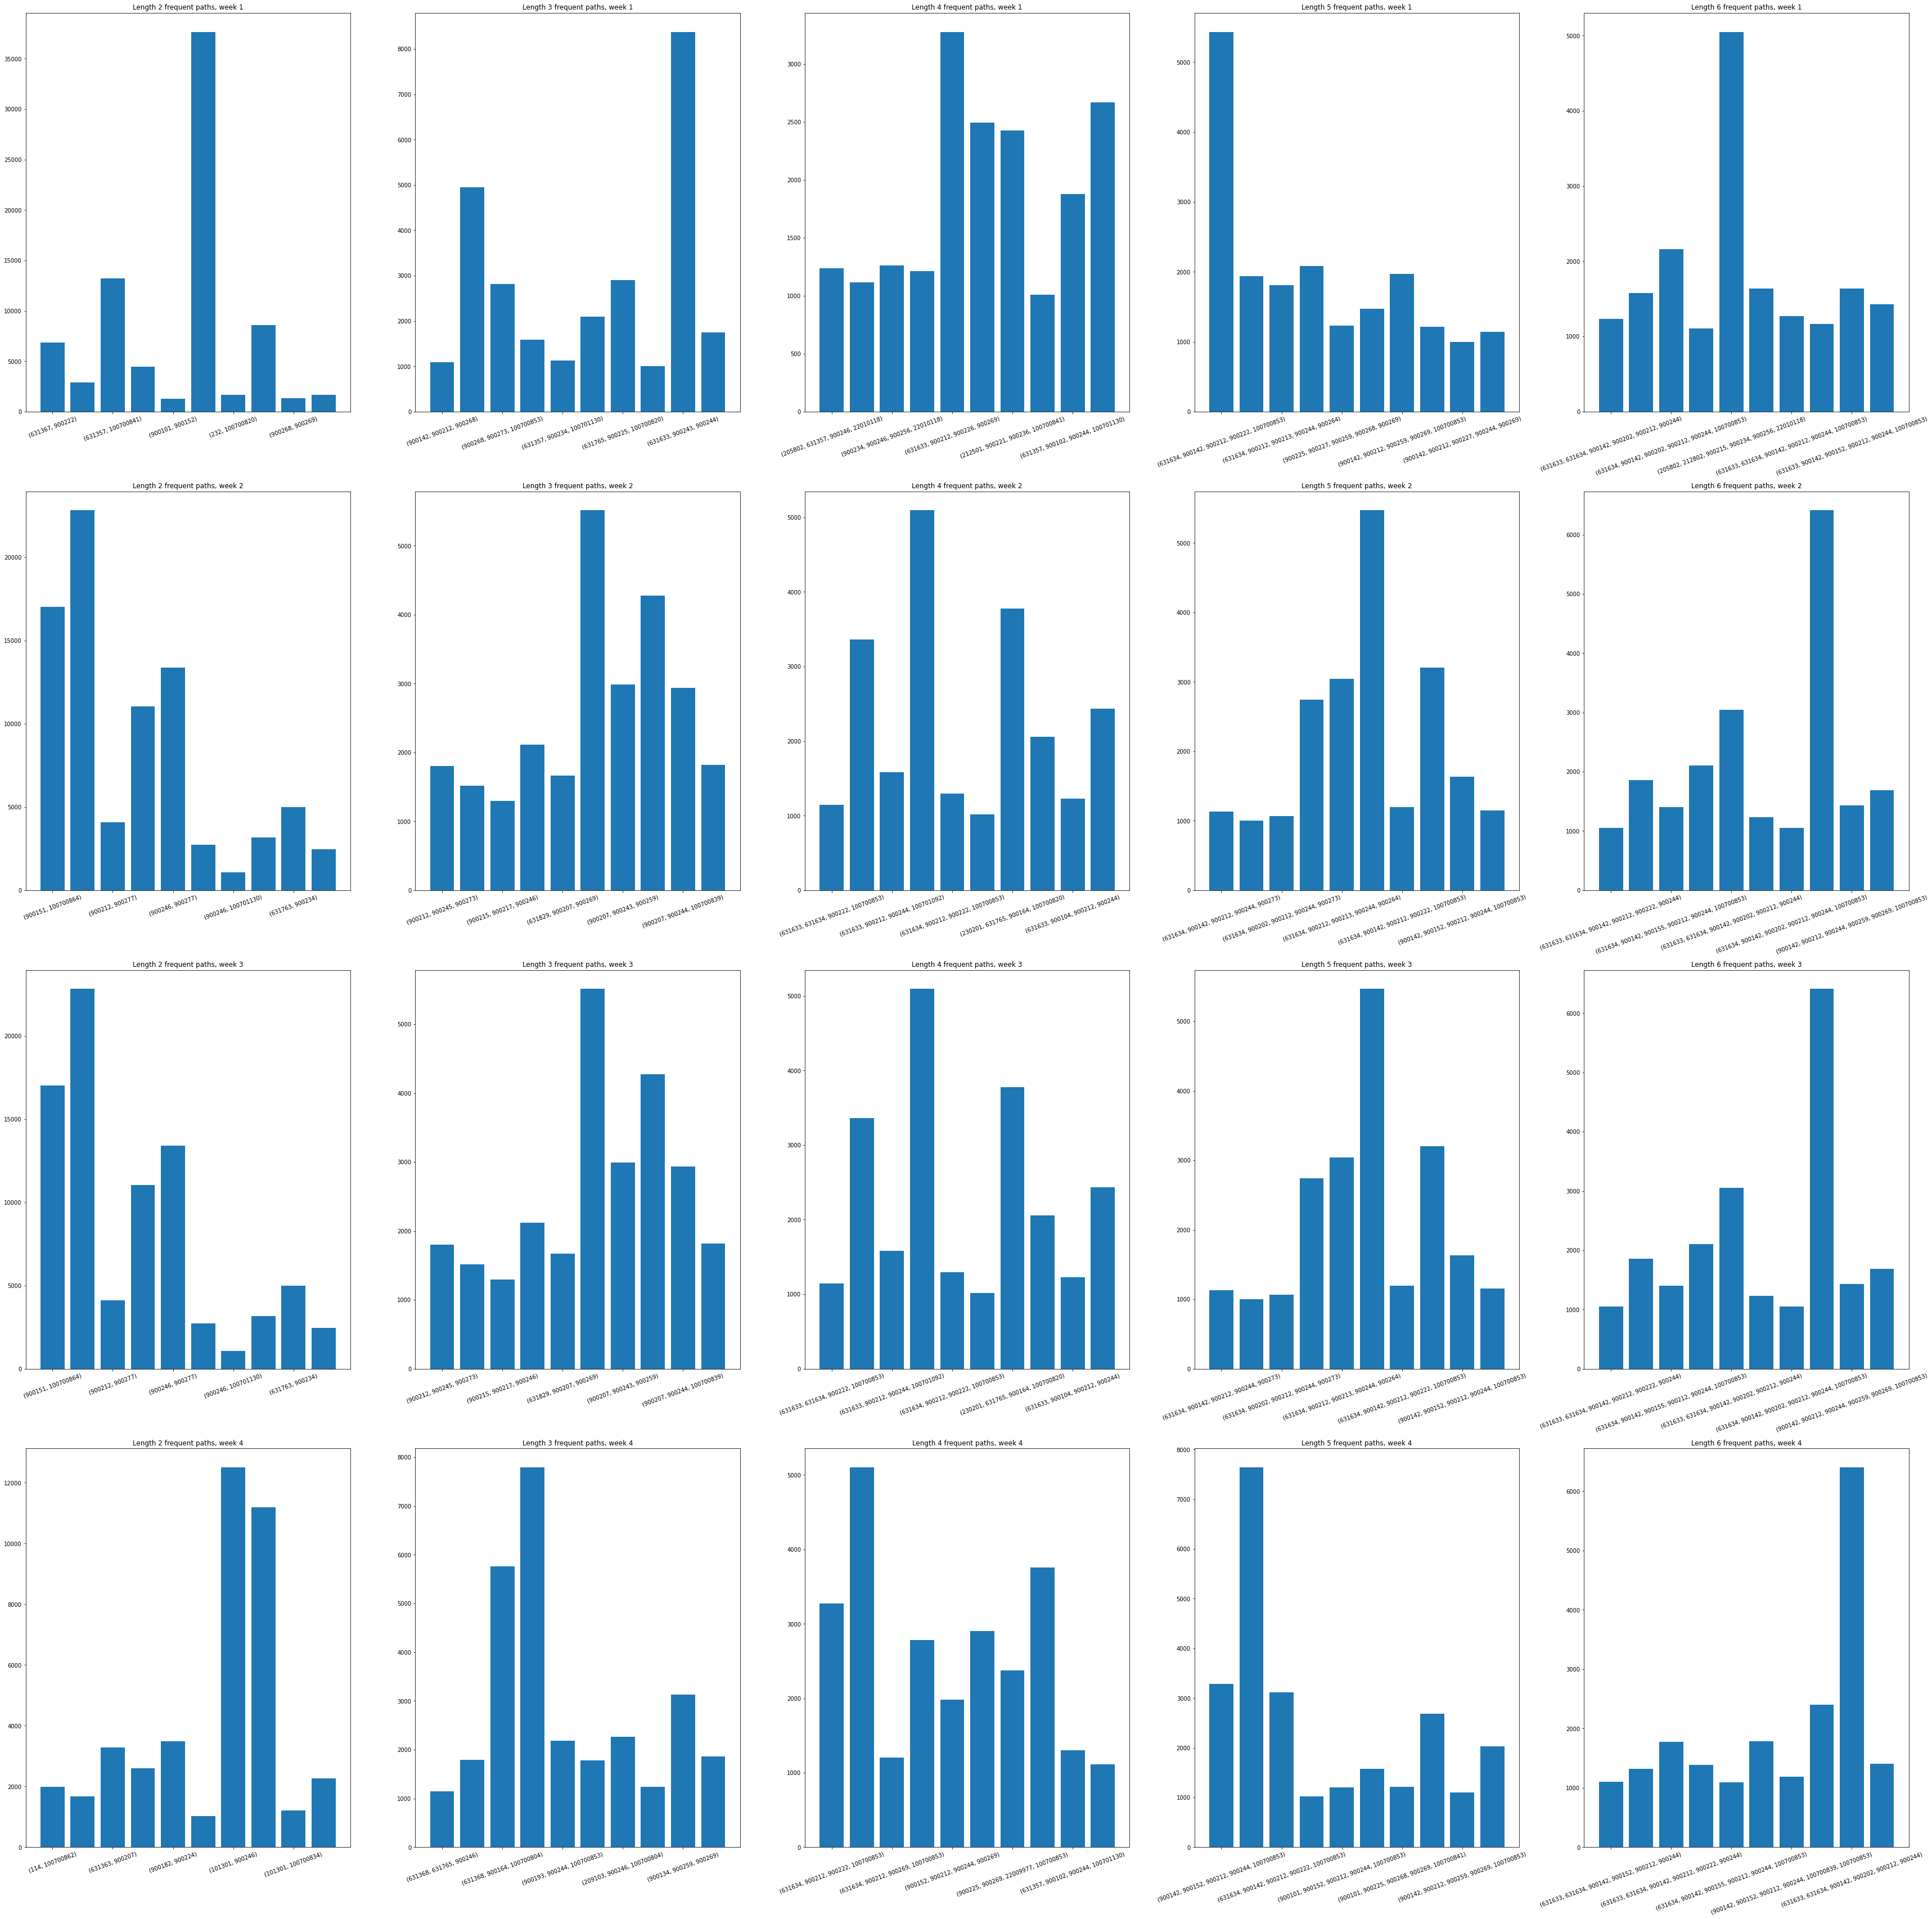

In [122]:
# on a grid of 4 rows and 5 columns, plot the top 10 frequent paths for each week

fig, axs = plt.subplots(4, 5, figsize=(60, 60))
for i in range(2, 6 + 1):
    axs[0, i - 2].bar(range(10), [frequent_paths_week1[i - 2][j][1]for j in range(10)])
    axs[0, i - 2].set_title(f"Length {i} frequent paths, week 1")
    axs[0, i - 2].set_xticklabels([frequent_paths_week1[i - 2][j][0]for j in range(10)], rotation=20)
    axs[1, i - 2].bar(range(10), [frequent_paths_week2[i - 2][j][1]for j in range(10)])
    axs[1, i - 2].set_title(f"Length {i} frequent paths, week 2")
    axs[1, i - 2].set_xticklabels([frequent_paths_week2[i - 2][j][0]for j in range(10)], rotation=20)
    axs[2, i - 2].bar(range(10), [frequent_paths_week3[i - 2][j][1]for j in range(10)])
    axs[2, i - 2].set_title(f"Length {i} frequent paths, week 3")
    axs[2, i - 2].set_xticklabels([frequent_paths_week3[i - 2][j][0]for j in range(10)], rotation=20)
    axs[3, i - 2].bar(range(10), [frequent_paths_week4[i - 2][j][1]for j in range(10)])
    axs[3, i - 2].set_title(f"Length {i} frequent paths, week 4")
    axs[3, i - 2].set_xticklabels([frequent_paths_week4[i - 2][j][0]for j in range(10)], rotation=20)

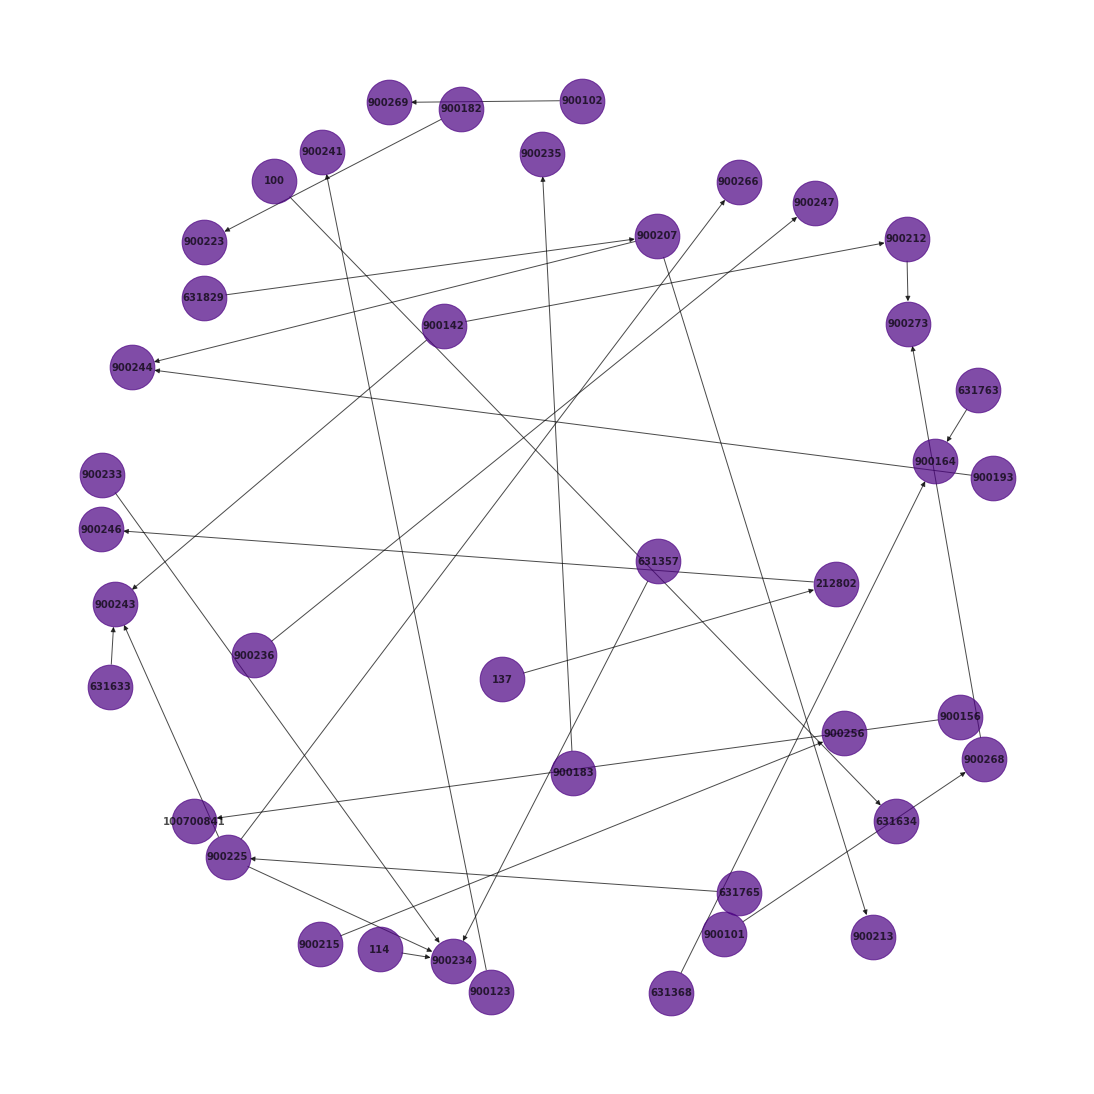

In [128]:
# visualize the graph of the frequent paths for week 1

visualize_frequent_paths(frequent_paths_week1[1], 3)